### What is Parallelization in LangGraph?

In LangGraph, nodes typically execute in a sequence defined by edges, but when tasks don't depend on each other's outputs, you can run them in parallel. This is achieved by:

* Defining multiple nodes that can operate independently.
* Connecting them to a common starting point (e.g., START or another node).
* Merging their outputs into a downstream node if needed.

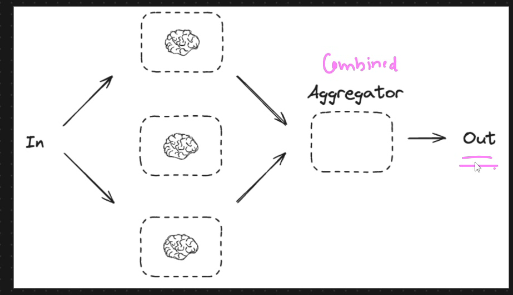

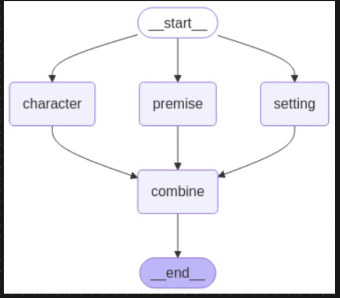

content='Hello. How can I assist you today?' response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 36, 'total_tokens': 46, 'completion_time': 0.008031915, 'prompt_time': 0.017591707, 'queue_time': 0.049740662, 'total_time': 0.025623622}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ddfbb0da0', 'finish_reason': 'stop', 'logprobs': None} id='run-e3c7894f-434d-409a-a360-159f69a86c43-0' usage_metadata={'input_tokens': 36, 'output_tokens': 10, 'total_tokens': 46}


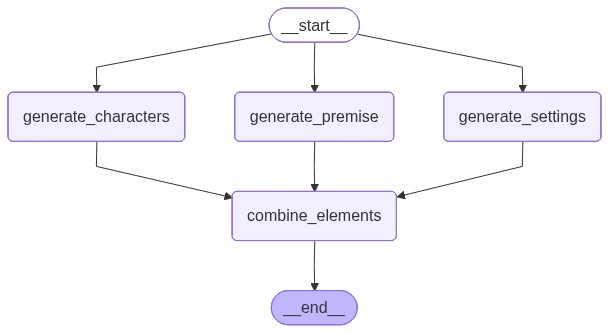

In [ ]:
# 🔹 Step 1: Load LLM (Language Model
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from typing import TypedDict

from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

llm = ChatGroq(model="llama-3.3-70b-versatile")
llm
# ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000002A063ACA360>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002A063C48B60>, model_name='llama-3.3-70b-versatile', groq_api_key=SecretStr('**********'))

result = llm.invoke("Hello")
print(result)
# content='Hello. How can I assist you today?' response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 36, 'total_tokens': 46, 'completion_time': 0.010225956, 'prompt_time': 0.010404202, 'queue_time': 0.051097118, 'total_time': 0.020630158}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'finish_reason': 'stop', 'logprobs': None} id='run-60f19d32-a3d8-4074-b361-99195982aa56-0' usage_metadata={'input_tokens': 36, 'output_tokens': 10, 'total_tokens': 46}

# 🔹 Step 2: Define the State
#Here we define the data we will use and pass through the graph.
class State(TypedDict):
    topic: str
    characters: str
    settings: str
    premise: str
    story_intro: str
#So these are the variables we will use in different nodes

#🔹 Step 3: Define the Nodes
#Now we’ll define the different parts of the story that can run in parallel.
def generate_characters(state: State) -> dict:
    message = llm.invoke(f"Create two character names and brief traits for a story about: {state['topic']}")
    return {"characters": message.content}

def generate_settings(state: State) -> dict:
    message = llm.invoke(f"Describe a vivid setting for a story about: {state['topic']}")
    return {"settings": message.content}

def generate_premise(state: State) -> dict:
    message = llm.invoke(f"Write a one sentence plot premise for a story about: {state['topic']}")
    return {"premise": message.content}

def combine_elements(state: State) -> dict:
    message = llm.invoke(
        f"Write a short story introduction using the following elements:\n"
        f"Characters: {state['characters']}\n"
        f"Settings: {state['settings']}\n"
        f"Premise: {state['premise']}"
    )
    return {"story_intro": message.content}

#This is the aggregator node.

# 🏗️ Step 5: Build the Graph
#We now create the graph and connect the nodes properly.
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
graph = StateGraph(State)
#✅ Add Nodes
graph.add_node("generate_characters", generate_characters)
graph.add_node("generate_settings", generate_settings)
graph.add_node("generate_premise", generate_premise)
graph.add_node("combine_elements", combine_elements)

#✅ Add Edges
#Now we connect everything:
# ✅ Add Edges
graph.add_edge(START, "generate_characters")
graph.add_edge(START, "generate_settings")
graph.add_edge(START, "generate_premise")

graph.add_edge("generate_characters", "combine_elements")
graph.add_edge("generate_settings", "combine_elements")
graph.add_edge("generate_premise", "combine_elements")

graph.add_edge("combine_elements", END)

#So all 3 parallel nodes (characters, settings, premise) start after START
#Then all 3 go into the combine node
#Then we go to END.

# ✅ Compile and run
compiled_graph = graph.compile()
graph_image = compiled_graph.get_graph().draw_mermaid_png()
display(Image(graph_image))




In [ ]:

# 🚀 Step 7: Run the Graph
state = {"topic": "time travel"}
result = compiled_graph.invoke(state)
print(result["story_intro"])
#As the last remnants of sunlight faded from the horizon, casting a warm orange glow over the deserted streets, Evelyn "Evie" Thompson stood at the base of the old, mysterious clock tower, her eyes fixed on the intricate carvings of gears and celestial bodies that adorned its stone walls. The once-majestic timepiece, now a relic of a bygone era, seemed to loom over her like a harbinger of forgotten secrets, its very presence stirring the thrill of discovery that had driven her to spend years studying the mysteries of time. With her latest invention, a time machine capable of manipulating the fabric of reality, Evie was on the cusp of a breakthrough that could change the course of history. But she knew she couldn't do it alone.
#That's why she had recruited James "Hawk" Hawkins, her childhood friend and a former soldier, to be her partner in this perilous journey through the ages. Hawk's rugged charm and combat skills would be invaluable in navigating the unpredictable dangers of the past and future, and his unwavering loyalty would be a beacon of comfort in the face of the unknown. As they prepared to embark on their maiden voyage through time, Evie's mind was racing with the endless possibilities and potential consequences of their actions. She had spent years studying the theories of time travel, but she knew that the reality would be far more complex, with every decision and event rippling out to alter the course of history in unforeseeable ways.
#Their mission was to prevent a catastrophic future from unfolding, one that Evie had glimpsed through the lens of her time machine. A future where the world was on the brink of collapse, where the very fabric of society was torn asunder by conflict and destruction. But as they stood before the clock tower, its pulse growing stronger with every passing moment, Evie couldn't shake the feeling that they were not just fighting to save the world, but also to confront the darker aspects of their own pasts. The clock tower, with its labyrinthine network of gears and pendulums, seemed to be waiting for them, its secrets and mysteries poised to reveal themselves to those brave enough to venture into its heart. And as Evie and Hawk step
#ped forward, ready to face whatever lay ahead, the stars began to twinkle in the night sky, like diamonds scattered across the velvet expanse, illuminating the path to a journey that would take them to the very limits of time and human endurance.



As the last remnants of sunlight faded from the horizon, casting a warm orange glow over the deserted streets, Evelyn "Evie" Thompson stood at the base of the old, mysterious clock tower, her eyes fixed on the intricate carvings of gears and celestial bodies that adorned its stone walls. The once-majestic timepiece, now a relic of a bygone era, seemed to loom over her like a harbinger of forgotten secrets, its very presence stirring the thrill of discovery that had driven her to spend years studying the mysteries of time. With her latest invention, a time machine capable of manipulating the fabric of reality, Evie was on the cusp of a breakthrough that could change the course of history. But she knew she couldn't do it alone.

That's why she had recruited James "Hawk" Hawkins, her childhood friend and a former soldier, to be her partner in this perilous journey through the ages. Hawk's rugged charm and combat skills would be invaluable in navigating the unpredictable dangers of the pas